<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/AT%26T_logo_2016.svg" alt="AT&T LOGO" width="50%" />

# Orange SPAM detector

## Company's Description 📇

AT&T Inc. is an American multinational telecommunications holding company headquartered at Whitacre Tower in Downtown Dallas, Texas. It is the world's largest telecommunications company by revenue and the third largest provider of mobile telephone services in the U.S. As of 2022, AT&T was ranked 13th on the Fortune 500 rankings of the largest United States corporations, with revenues of $168.8 billion! 😮

## Project 🚧

One of the main pain point that AT&T users are facing is constant exposure to SPAM messages.

AT&T has been able to manually flag spam messages for a time, but they are looking for an automated way of detecting spams to protect their users.

## Goals 🎯

Your goal is to build a spam detector, that can automatically flag spams as they come based solely on the sms' content.

## Scope of this project 🖼️

To start off, AT&T would like you to use the folowing dataset:

[Dowload the Dataset](https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv)

## Helpers 🦮

To help you achieve this project, here are a few tips that should help you:

### Start simple
A good deep learing model does not necessarily have to be super complicated!

### Transfer learning
You do not have access to a whole lot of data, perhaps channeling the power of a more sophisticated model trained on billions of observations might help!

## Deliverable 📬

To complete this project, your team should:

* Write a notebook that runs preprocessing and trains one or more deep learning models in order to predict the spam or ham nature of the sms
* State the achieved performance clearly

In [1]:
# Import Tensorflow & Pathlib librairies
import tensorflow as tf
import pathlib
import pandas as pd
import os
import io
import warnings
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv("https://full-stack-bigdata-datasets.s3.eu-west-3.amazonaws.com/Deep+Learning/project/spam.csv", encoding="ISO-8859-1")
dataset.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Exploratory Dataset and Data Visualization

In [3]:
dataset.shape

(5572, 5)

In [4]:
print("Percentage of missing values: ")
display(100 * dataset.isnull().sum() / dataset.shape[0])

Percentage of missing values: 


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

In [5]:
to_drop = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"]
dataset = dataset.drop(to_drop, axis=1)
dataset.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
dataset.duplicated().sum()# There are 403 dupliacted values in the dataset

403

In [7]:
dataset.drop_duplicates(inplace = True)
dataset.shape

(5169, 2)

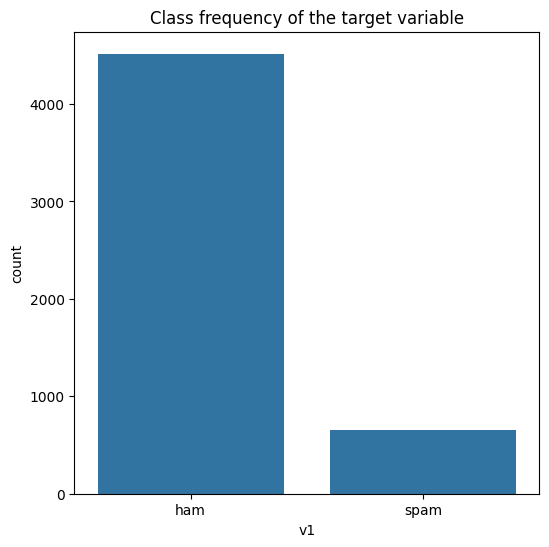

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.figure(figsize = [6, 6])#, clear = True, facecolor = "white")

sns.barplot(x = dataset["v1"].value_counts().index, y = dataset["v1"].value_counts()).set(title = "Class frequency of the target variable");
#, saturation = 1).set(title = "Class frequency of the target variable");

## Cleaning and preparation of Data for training

In [9]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [10]:
# Import Stop words
from spacy.lang.en.stop_words import STOP_WORDS

In [11]:
# remove all characters from strings that are not alphanumeric except for whitespaces, and apostrophies.
dataset["v2_clean"] = dataset["v2"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))

# replace double whitespaces with single whitespaces, convert all characters to lowercase and trim starting and finishing whitespaces.
dataset["v2_clean"] = dataset["v2_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())

#replace all tokens in your texts with lemma_ (which is ROOT words) and remove all the stop words.
dataset["v2_clean"] = dataset["v2_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

dataset

,v1,v2,v2_clean
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,2nd time try 2 contact u u win å750 pound priz...
5568,ham,Will Ì_ b going to esplanade fr home?,ì b esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",pity mood soany suggestion
5570,ham,The guy did some bitching but I acted like i'd...,guy bitching act like interested buy week free


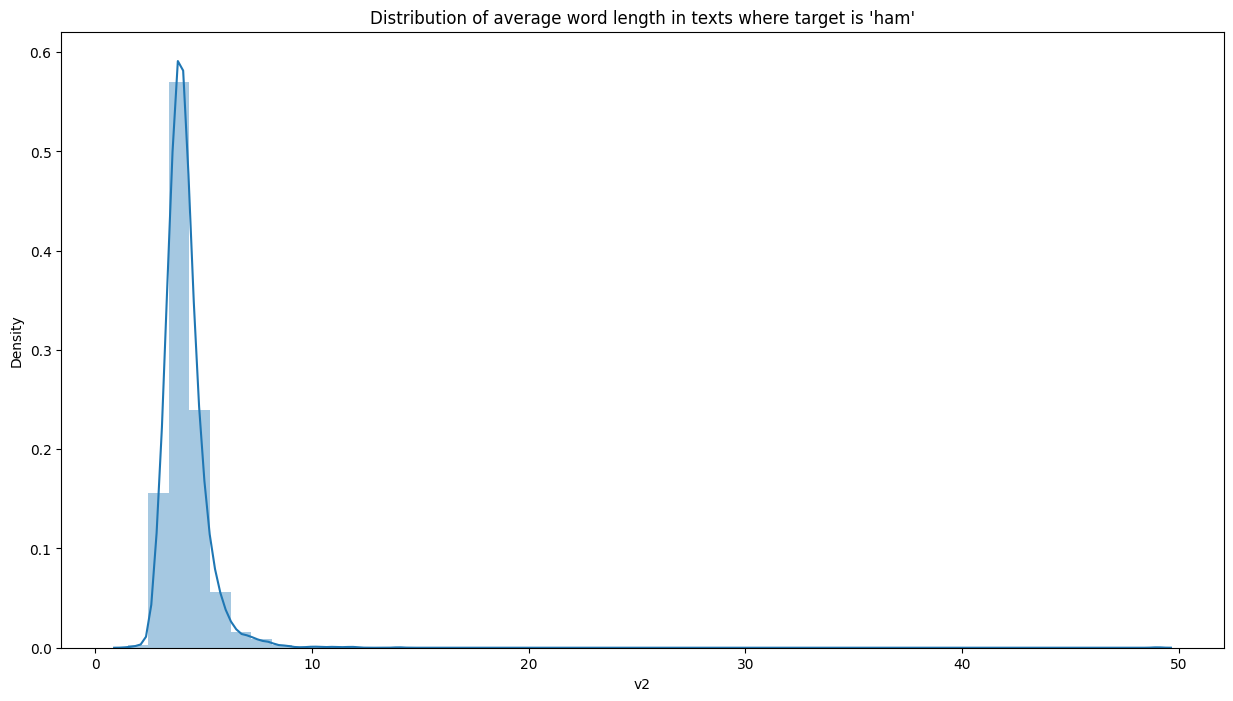

In [21]:
import numpy as np
fig,ax = plt.subplots(figsize = (15, 8))
text_words = dataset[dataset["v1"] == "ham"]["v2"].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(text_words.map(lambda x: np.mean(x)), ax = ax).set_title("Distribution of average word length in texts where target is 'ham'");

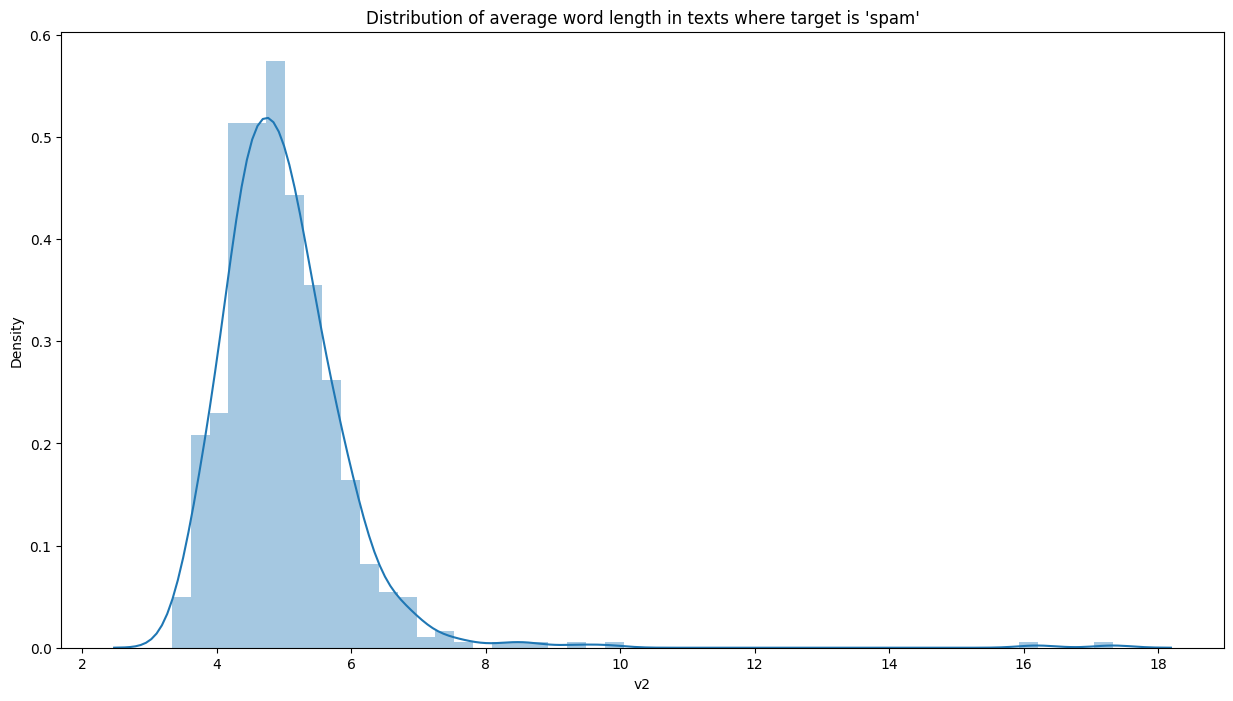

In [22]:
import numpy as np
fig,ax = plt.subplots(figsize = (15, 8))
text_words = dataset[dataset["v1"] == "spam"]["v2"].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(text_words.map(lambda x: np.mean(x)), ax = ax).set_title("Distribution of average word length in texts where target is 'spam'");

In [12]:
def convert_to_binary(text):
    if text == "ham":
        return 0
    else:
        return 1

#Apply to the column
dataset['target'] = dataset['v1'].apply(convert_to_binary)
dataset.head()

,v1,v2,v2_clean,target
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,1
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,0


In [28]:
#from sklearn.preprocessing import LabelEncoder
#lb = LabelEncoder()
#dataset["v1_lb"] = lb.fit_transform(dataset["v1"])

In [42]:
dataset.head()

,v1,v2,v2_clean,target
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,0
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,1
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,0


## Tokenizing and Padding

In [13]:
from collections import Counter
import re

#Function to tokenize text into words
def tokenize(text):
    words = re.findall(r'\b\w+\b', text.lower())
    return words

#Tokenize text in the column
words_list = dataset['v2_clean'].apply(tokenize)

#Flatten the list of lists into a single list
all_words = [word for sublist in words_list for word in sublist]

#Count unique words
unique_word_count = len(Counter(all_words))

print("Number of unique words:", unique_word_count)

Number of unique words: 8165


In [14]:
import numpy as np
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=8200, oov_token="out_of_vocab") # instanciate the tokenizer
tokenizer.fit_on_texts(dataset.v2_clean)
dataset["v2_encoded"] = tokenizer.texts_to_sequences(dataset.v2_clean)
dataset.head()


,v1,v2,v2_clean,target,v2_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,0,"[3139, 211, 408, 485, 845, 32, 51, 262, 846, 7..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,0,"[10, 175, 486, 263, 2, 1320]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,1,"[11, 336, 3, 698, 699, 39, 2075, 981, 460, 207..."
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,0,"[2, 114, 135, 2080, 2, 76]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,0,"[663, 18, 605, 147]"


## Padding

In [15]:

v2_pad = tf.keras.preprocessing.sequence.pad_sequences(dataset.v2_encoded, padding="post")
# add 0 at the end (padding="post" or at the beginning padding ="pre") of the sequences so that they all have equal length.

## Train Test Split

In [19]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(v2_pad, dataset.target, test_size=0.3, stratify = dataset.target, random_state = 0)

## creation of tensor dataset for the training, and validation set

In [20]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

## use .shuffle and .batch on both sets to organise them by batches of 64 observations

In [21]:
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [22]:
 # Have a look at the first batch
for v2, v1 in train_batch.take(1):
  print(v2, v1)

tf.Tensor(
[[   4 6125 6126 ...    0    0    0]
 [   2  252  568 ...    0    0    0]
 [  94  566  710 ...    0    0    0]
 ...
 [   3 4298 2529 ...    0    0    0]
 [  18 5251  670 ...    0    0    0]
 [ 428  362 1940 ...    0    0    0]], shape=(64, 74), dtype=int32) tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0], shape=(64,), dtype=int64)


## DEEP LEARNING Model: Global Average Pooling

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
#from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import TextVectorization

embedding_dim=8 # the dimensionality of the representation space

vocab_size = tokenizer.num_words # the number of words in the vocabulary
model = Sequential([

  Embedding(vocab_size+1, embedding_dim, input_shape=[v2.shape[1],], name="embedding"), # the embedding layer
  # the input dim needs to be equal to the size of the vocabulary + 1 (because of the zero padding)
  GlobalAveragePooling1D(), # this will pick the average for every word in the sentence along each dimension of the representation space.
  Dense(16, activation='relu'), # a dense layer
  Dense(1, activation="sigmoid")]) # the prediction layer

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 8)             65608     
                                                                 
 global_average_pooling1d (  (None, 8)                 0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 65769 (256.91 KB)
Trainable params: 65769 (256.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy',])

In [25]:
history = model.fit(train_batch, validation_data = val_batch, epochs=20)

Epoch 1/20
57/57 [==============================] - 1s 6ms/step - loss: 0.6572 - accuracy: 0.8452 - val_loss: 0.6126 - val_accuracy: 0.8736
Epoch 2/20
57/57 [==============================] - 0s 4ms/step - loss: 0.5363 - accuracy: 0.8737 - val_loss: 0.4505 - val_accuracy: 0.8736
Epoch 3/20
57/57 [==============================] - 0s 3ms/step - loss: 0.3962 - accuracy: 0.8737 - val_loss: 0.3596 - val_accuracy: 0.8736
Epoch 4/20
57/57 [==============================] - 0s 4ms/step - loss: 0.3492 - accuracy: 0.8737 - val_loss: 0.3445 - val_accuracy: 0.8736
Epoch 5/20
57/57 [==============================] - 0s 3ms/step - loss: 0.3399 - accuracy: 0.8737 - val_loss: 0.3383 - val_accuracy: 0.8736
Epoch 6/20
57/57 [==============================] - 0s 3ms/step - loss: 0.3328 - accuracy: 0.8737 - val_loss: 0.3316 - val_accuracy: 0.8736
Epoch 7/20
57/57 [==============================] - 0s 4ms/step - loss: 0.3247 - accuracy: 0.8737 - val_loss: 0.3244 - val_accuracy: 0.8736
Epoch 8/20
57/57 [==

In [26]:
print("Model accuracy on the train set: ", model.evaluate(xtrain, ytrain)[1])
print()
print("Model accuracy on the Val set: ", model.evaluate(xval, yval)[1])

114/114 [==============================] - 1s 2ms/step - loss: 0.0599 - accuracy: 0.9820
Model accuracy on the train set:  0.9820342659950256

49/49 [==============================] - 0s 2ms/step - loss: 0.0874 - accuracy: 0.9781
Model accuracy on the Val set:  0.9780786633491516


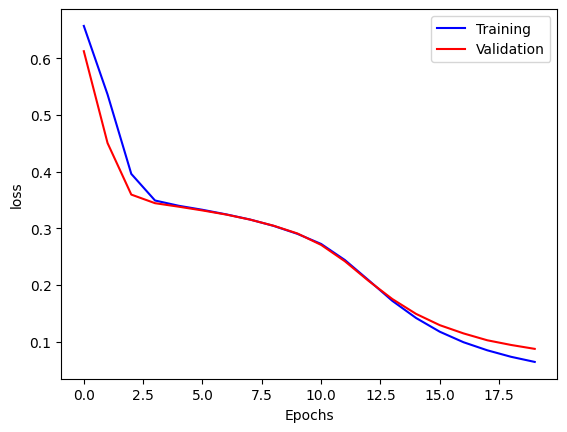

In [27]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history.history["loss"], color="b", label = "Training")
plt.plot(history.history["val_loss"], color="r", label = "Validation")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

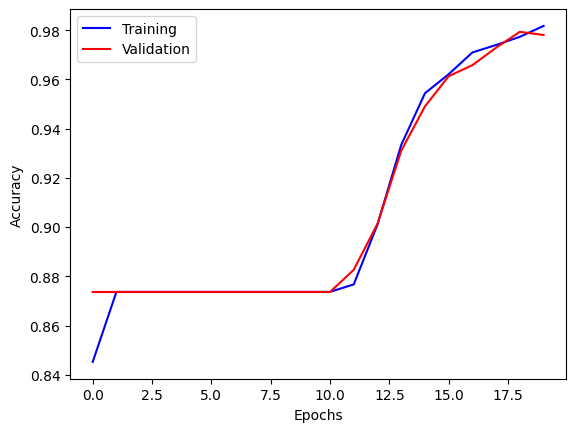

In [28]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history.history["accuracy"], color="b", label = "Training")
plt.plot(history.history["val_accuracy"], color="r", label = "Validation")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [29]:
prediction = model.predict(xval)
classes_pred = np.argmax(prediction, axis = 1)

print(classification_report(yval, classes_pred))

49/49 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1355
           1       0.00      0.00      0.00       196

    accuracy                           0.87      1551
   macro avg       0.44      0.50      0.47      1551
weighted avg       0.76      0.87      0.81      1551



[[1355    0]
 [ 196    0]]


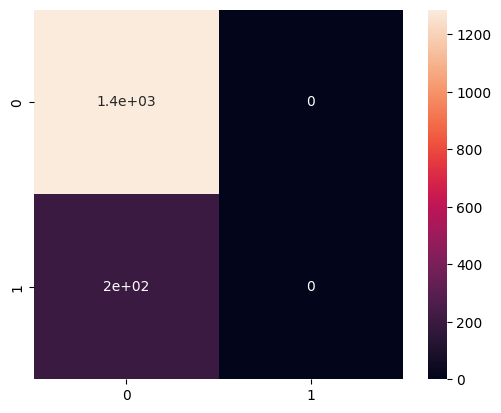

In [30]:
conf_mat = confusion_matrix(yval, classes_pred)
print(conf_mat)

sns.heatmap(conf_mat, square = True, annot = True, robust = True)
plt.show()

## DEEP LEARNING: LSTM - Long Short-Term Memory Model

In [31]:
embedding_dim=8 # the dimensionality of the representation space
n_lstm = 64

vocab_size = tokenizer.num_words
model_lstm = tf.keras.Sequential([
 # PLUS DE VECTORIZED LAYER CAR ON L'A FAIT NOUS MEME À LA MAIN
  tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_shape=[v2.shape[1],], name="embedding"), # the embedding layer
  tf.keras.layers.LSTM(n_lstm), # return_sequences=True),
  #tf.keras.layers.Dense(64, activation='relu'), # a dense layer
  tf.keras.layers.Dense(1, activation="sigmoid") # the prediction layer
])

model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 74, 8)             65608     
                                                                 
 lstm (LSTM)                 (None, 64)                18688     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 84361 (329.54 KB)
Trainable params: 84361 (329.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy',])

In [33]:
history_lstm = model_lstm.fit(train_batch, validation_data=val_batch, epochs=20)

Epoch 1/20
57/57 [==============================] - 6s 58ms/step - loss: 0.4505 - accuracy: 0.8737 - val_loss: 0.3793 - val_accuracy: 0.8736
Epoch 2/20
57/57 [==============================] - 3s 49ms/step - loss: 0.3816 - accuracy: 0.8737 - val_loss: 0.3808 - val_accuracy: 0.8736
Epoch 3/20
57/57 [==============================] - 4s 63ms/step - loss: 0.3805 - accuracy: 0.8737 - val_loss: 0.3804 - val_accuracy: 0.8736
Epoch 4/20
57/57 [==============================] - 3s 50ms/step - loss: 0.3804 - accuracy: 0.8737 - val_loss: 0.3787 - val_accuracy: 0.8736
Epoch 5/20
57/57 [==============================] - 3s 53ms/step - loss: 0.3379 - accuracy: 0.8864 - val_loss: 0.1181 - val_accuracy: 0.9703
Epoch 6/20
57/57 [==============================] - 4s 64ms/step - loss: 0.1252 - accuracy: 0.9489 - val_loss: 0.1785 - val_accuracy: 0.9226
Epoch 7/20
57/57 [==============================] - 3s 51ms/step - loss: 0.1261 - accuracy: 0.9428 - val_loss: 0.1825 - val_accuracy: 0.9207
Epoch 8/20
57

In [34]:
print("Model accuracy on the train set: ", model_lstm.evaluate(xtrain, ytrain)[1])
print()
print("Model accuracy on the Val set: ", model_lstm.evaluate(xval, yval)[1])

114/114 [==============================] - 3s 12ms/step - loss: 0.3739 - accuracy: 0.8737
Model accuracy on the train set:  0.8736871480941772

49/49 [==============================] - 1s 11ms/step - loss: 0.3761 - accuracy: 0.8736
Model accuracy on the Val set:  0.8736299276351929


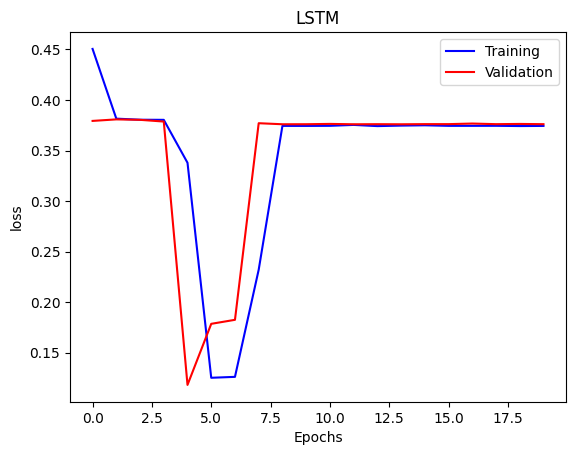

In [35]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function
plt.plot(history_lstm.history["loss"], color="b", label = "Training")
plt.plot(history_lstm.history["val_loss"], color="r", label = "Validation")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.title("LSTM")
plt.legend()
plt.show()

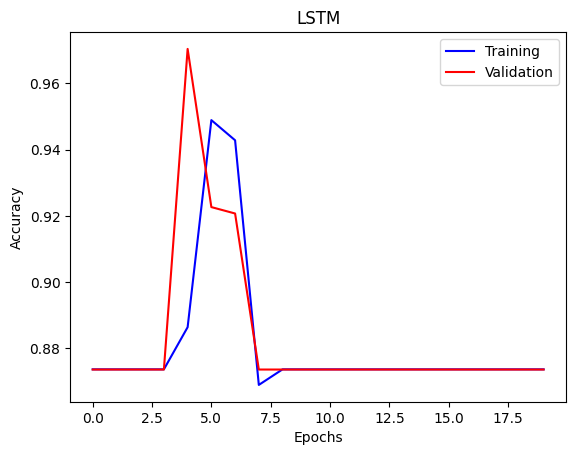

In [36]:
# Visualization of the training process on the loss function
plt.plot(history_lstm.history["accuracy"], color="b", label = "Training")
plt.plot(history_lstm.history["val_accuracy"], color="r", label = "Validation")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.title("LSTM")
plt.legend()
plt.show()

In [37]:
prediction = model_lstm.predict(xval)
classes_pred = np.argmax(prediction, axis = 1)

print(classification_report(yval, classes_pred))

49/49 [==============================] - 1s 16ms/step
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1355
           1       0.00      0.00      0.00       196

    accuracy                           0.87      1551
   macro avg       0.44      0.50      0.47      1551
weighted avg       0.76      0.87      0.81      1551



[[1355    0]
 [ 196    0]]


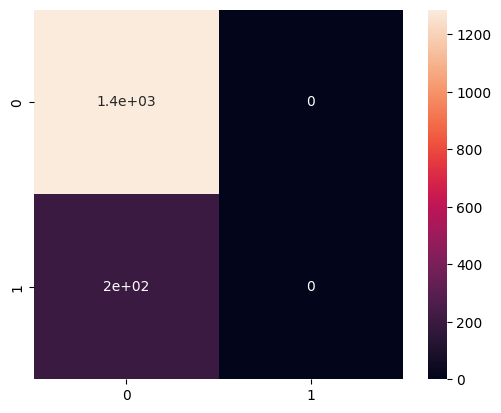

In [38]:
conf_mat = confusion_matrix(yval, classes_pred)
print(conf_mat)

sns.heatmap(conf_mat, square = True, annot = True, robust = True)
plt.show()

## Neural Network in this case in our case is unable to predict spam. Probably because of inbalanced classes problem

## NAIVE BAYES Classifier Model

In [45]:
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report


# Applying SMOTE to the training data
smote = SMOTE(random_state=42)
xtrain_resampled, ytrain_resampled = smote.fit_resample(xtrain, ytrain)

# Training the Naive Bayes classifier
clf = MultinomialNB()
clf.fit(xtrain_resampled, ytrain_resampled)
#clf.fit(xtrain, ytrain)

# Making predictions
ypred = clf.predict(xval)

# Evaluating the model
accuracy = accuracy_score(yval, ypred)
report = classification_report(yval, ypred)

print("Accuracy on the Val set:", accuracy)
print("Classification Report:\n", report)

Accuracy on the Val set: 0.8903932946486138
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.90      0.94      1355
           1       0.55      0.79      0.65       196

    accuracy                           0.89      1551
   macro avg       0.76      0.85      0.79      1551
weighted avg       0.91      0.89      0.90      1551



[[1226  129]
 [  41  155]]


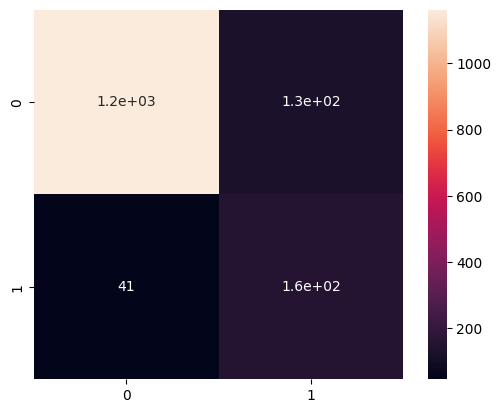

In [46]:

conf_mat = confusion_matrix(yval, ypred)
print(conf_mat)

sns.heatmap(conf_mat, square = True, annot = True, robust = True)
plt.show()

In [ ]:
# With Imbalanced classes

#Confusion Matrix
 [[1232  123]
 [  41  155]]
#Accuracy on Val test
 0.8942617666021921

## Multinomial Naive Bayes is able to predict SPAM with 0.89 accuracy on validation test.